In [29]:
import argparse
import os 
class Args(argparse.Namespace):
    data="/scratch/guest187/Data/val_SSA/monai"
    # data = "/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/data/val_SSA/monai/"
    preproc_set="val"
    data_used="SSA"
    # results='/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/data/val_SSA/results/'
    results='/scratch/guest187/Data/val_SSA/results/monai_test/'
    optimiser="adam"
    criterion="dice"
    exec_mode="predict"
    seed=42
    batch_size=4
    val_batch_size=2
    ckpt_path='/scratch/guest187/Data/train_all/results/test_fullRunThrough/best_metric_model_fullTest.pth'
    # ckpt_path='/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/data/best_metric_model_fullTest.pth'
args=Args()

In [10]:
import sys 
# sys.path.append('/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/scripts')
sys.path.append('/home/guest187/GitRepo_Brats23/UNN_BraTS23/scripts')
import modelZoo_monai as mZoo
import data_loader as dl
from monai_functions import (
    save_checkpoint,
    define_dataloaders,
    model_params,
    val_params,
    train)

import numpy as np 
import matplotlib.pyplot as plt
import torch
from monai.networks.nets import UNet
import nibabel as nib

In [11]:
def define_model(checkpoint=None):
    model=UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=4,
        channels=(16, 32, 64, 128, 256),
        # channels=(32, 64, 128, 256, 320, 320), #nnunet channels, depth 6
        # channels=(64, 96, 128, 192, 256, 384, 512), # optinet, depth 7
        strides=(2, 2, 2, 2), # length should = len(channels) - 1
        # kernel_size=,
        # num_res_units=,
        # dropout=0.0,
        )
    n_channels = len(model.channels)
    print(f"Number of channels: {n_channels}")

    if checkpoint != None:
        model.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))

    return model, n_channels

In [12]:
# pth = '/scratch/guest187/Data/train_gli_hack/results_hack_finetune_ssa/checkpoints/f0_finetune/epoch=39-dice=91.38.ckpt'
# pth = '/scratch/guest187/Data/train_all/results/test_fullRunThrough/best_metric_model_fullTest.pth'
pth = args.ckpt_path
checkpoint = torch.load(pth, map_location=torch.device('cpu'))
keys = checkpoint.keys()

# for key in checkpoint.keys():
#     print(key)

In [13]:
# define inference method
from monai.inferers import sliding_window_inference
def inference(VAL_AMP, model, input):
    def _compute(input):
        '''
        roi_size – the spatial window size for inferences. 
        When its components have None or non-positives, the corresponding inputs dimension will be used. 
        if the components of the roi_size are non-positive values, the transform will use the corresponding components of img size.
        For example, roi_size=(32, -1) will be adapted to (32, 64) if the second spatial dimension size of img is 64
        '''
        return sliding_window_inference(
            inputs=input,
            roi_size=None,
            sw_batch_size=4, #sw_batch_size denotes the max number of windows per network inference iteration, not the batch size of inputs.
            predictor=model,
            overlap=0.2,
            mode='constant'
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [15]:
validation_dir=args.data
validation_files = [os.path.join(validation_dir, file) for file in os.listdir(validation_dir)]
print('\n'.join(validation_files))
# checkpoint to test: finetuned hackathon model brats21
# checkpoint = '/scratch/guest187/Data/train_gli_hack/results_hack_finetune_ssa/checkpoints/f0_finetune/epoch=39-dice=91.38.ckpt'
# checkpoint2 = '/scratch/guest187/Data/train_all/results/test_fullRunThrough/best_metric_model_fullTest.pth'

model, n_channels = define_model(pth)

# Load validation data to dataloader
data_transforms = dl.define_transforms(n_channels)
dataloader = dl.load_data(args, data_transforms)

val_loader = dataloader['val']

# Validation parameters
VAL_AMP, dice_metric, dice_metric_batch, post_transforms = val_params()

/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00129-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00169-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00192-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00143-000
/scratch/guest187/Data/val_SSA/monai/dataset.json
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00126-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00227-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00139-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00148-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00218-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00188-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00210-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00198-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00132-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00158-000
/scratch/guest187/Data/val_SSA/monai/BraTS-SSA-00180-000
Number of channels: 5


In [16]:
max_idx = 2
for step, batch in enumerate(val_loader):
    if step < max_idx:
        input = batch[0]
        print(input.shape)
        print(str(batch[1]).split('/')[-1].replace("-stk.npy',)", ""))
    

Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
torch.Size([1, 4, 192, 192, 128])
BraTS-SSA-00129-000
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
torch.Size([1, 4, 192, 192, 128])
BraTS-SSA-00169-000
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'n

Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
<class 'numpy.ndarray'>
<class 'str'>


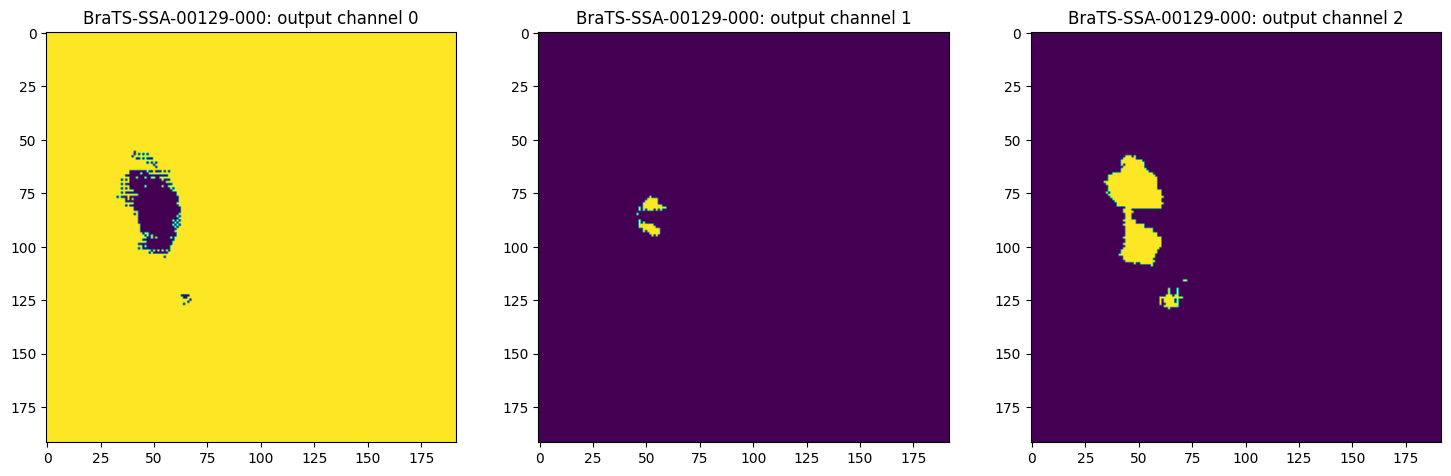

Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
<class 'numpy.ndarray'>
<class 'str'>


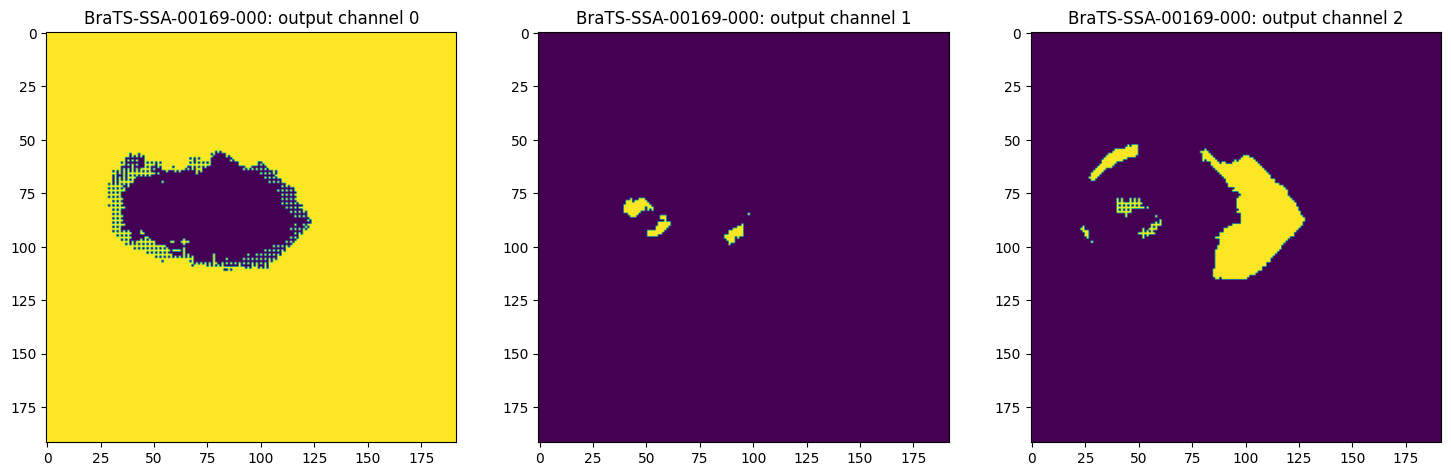

Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)
Tranformed_subject:  Subject(Keys: ('image', 'name'); images: 1)


In [22]:
max_idx = 2
with torch.no_grad():
    for step, batch in enumerate(val_loader):
        if step < max_idx:
            input = batch[0]
            case = str(batch[1]).split('/')[-1].replace("-stk.npy',)", "")
            # print(input.shape)
            output = inference(VAL_AMP, model, input)
            # print(output.shape)
            val_output = post_transforms(output[0])
            # print(val_output.shape)
            
            # visualize the 3 channels model output corresponding to this image
            plt.figure("model output", (18, 6))
            for i in range(3):
                plt.subplot(1, 3, i + 1)
                plt.title(f"{case}: output channel {i}")
                plt.imshow(val_output[i, :, :, 75])
            plt.show()


In [25]:
def infer():
    with torch.no_grad():
        for step, batch in enumerate(val_loader):
            input = batch[0]
            case = str(batch[1]).split('/')[-1].replace("-stk.npy',)", "")
            output = inference(VAL_AMP, model, input)
            val_output = post_transforms(output[0])
            val_output2 = val_output.cpu().numpy()
            val_out_pth = os.path.join(args.results, f"{case}_preds.npy")
            try:
                np.save(val_out_pth, val_output2)
            except Exception as e:
                print(f"An error occurred while saving the file: {e}")
            # Save to nifti


In [23]:
def save_nifti(tensor, outfile):
    '''
    Save tensor to NIfTI format
    '''
    # Create a NIfTI image object with the tensor data
    nifti_image = nib.Nifti1Image(tensor, affine=np.eye(4)) # Set affine?
    # Save the NIfTI image to a file
    nib.save(nifti_image, outfile)

In [ ]:
infer()


In [47]:
import os
from glob import glob
from subprocess import call

import nibabel as nib
import numpy as np
from scipy.ndimage.measurements import label

def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.5, pred[1] > 0.5, pred[2] > 0.5
    pred = (c1 > 0).astype(np.uint8)
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4

    components, n = label(pred == 4)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 8 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1

    et = pred == 4
    if 0 < et.sum() and et.sum() < 73 and np.mean(enh[et]) < 0.9:
        pred[et] = 1

    # pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    return pred


def prepare_preditions(e):
    fname = e[0].split("/")[-1].split(".")[0][:-6]
    print(fname)
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))

    img = nib.load(f"/scratch/guest187/Data/val_SSA/finetune_ssa/images/{fname}-stk.nii.gz")
    nib.save(
        nib.Nifti1Image(p, img.affine, header=img.header),
        os.path.join(args.results, fname + ".nii.gz"),
    )


try:
    os.makedirs(os.path.join(args.results, "final_preds"))
except:
    print("directory exists")
preds = sorted(glob('/scratch/guest187/Data/val_SSA/results/monai_test/'))
examples = list(zip(*[sorted(glob(f"{p}/*.npy")) for p in preds]))
print("Preparing final predictions")
for e in examples:
    prepare_preditions(e)

/tmp/ipykernel_96729/3731707343.py:7: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


directory exists
Preparing final predictions
BraTS-SSA-00126-000
BraTS-SSA-00129-000
BraTS-SSA-00132-000
BraTS-SSA-00139-000
BraTS-SSA-00143-000
BraTS-SSA-00148-000
BraTS-SSA-00158-000
BraTS-SSA-00169-000
BraTS-SSA-00180-000
BraTS-SSA-00188-000
BraTS-SSA-00192-000
BraTS-SSA-00198-000
BraTS-SSA-00210-000
BraTS-SSA-00218-000
BraTS-SSA-00227-000


BraTS-SSA-00126-000


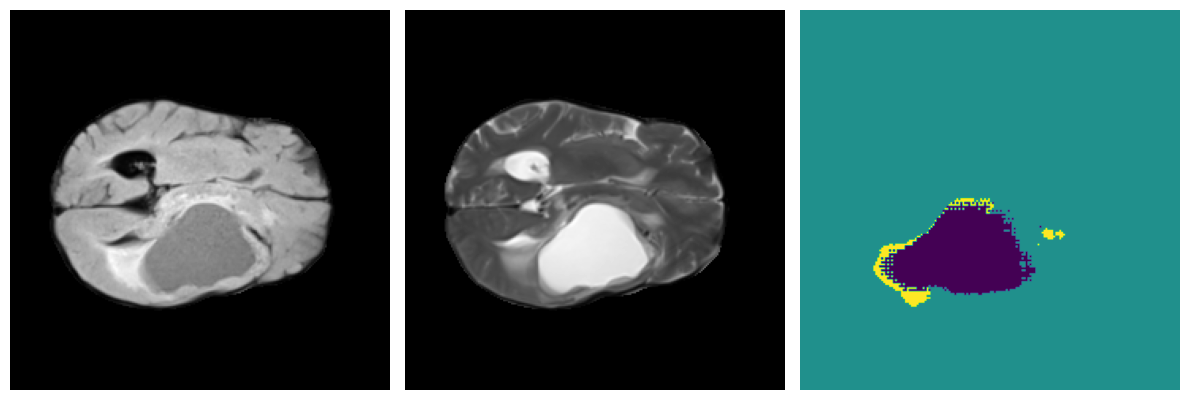

BraTS-SSA-00129-000


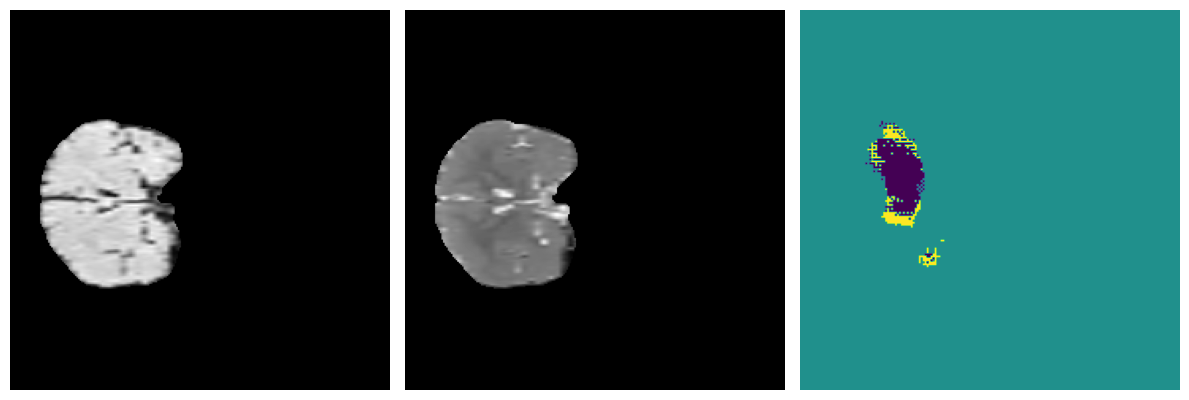

BraTS-SSA-00132-000


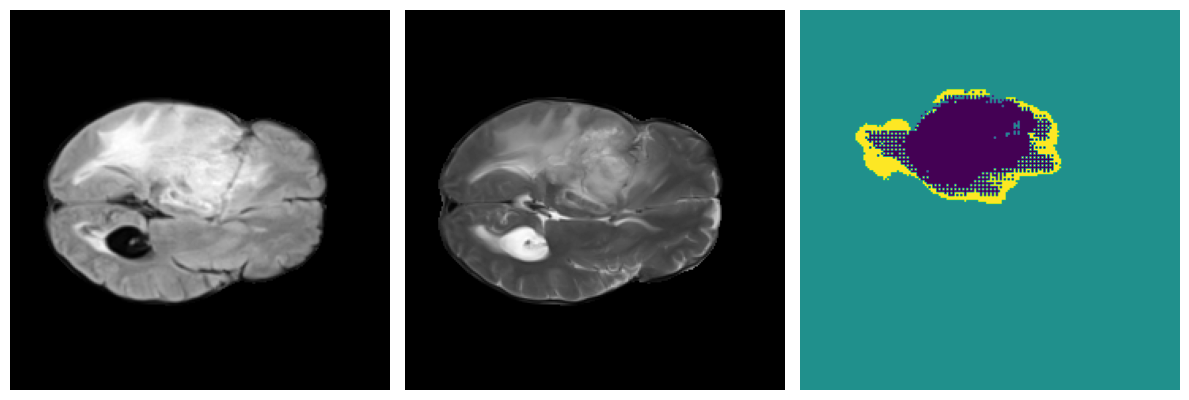

BraTS-SSA-00139-000


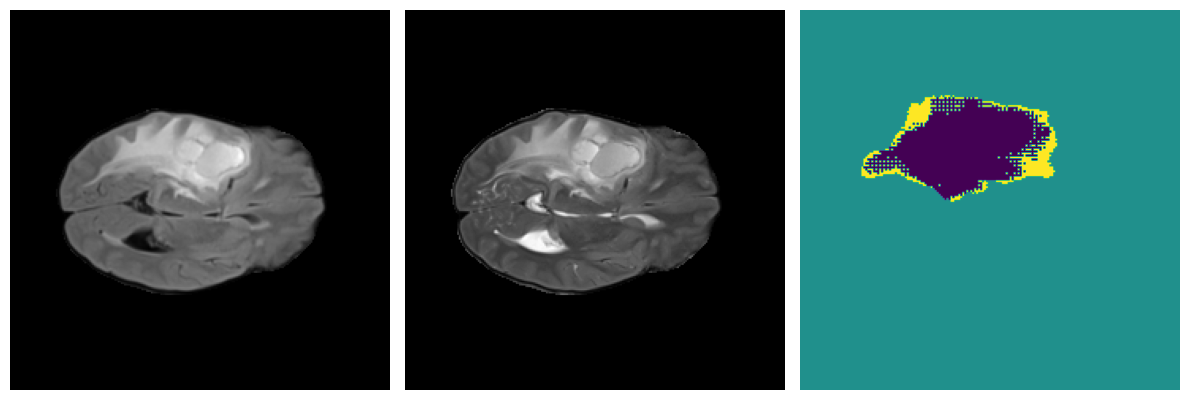

BraTS-SSA-00143-000


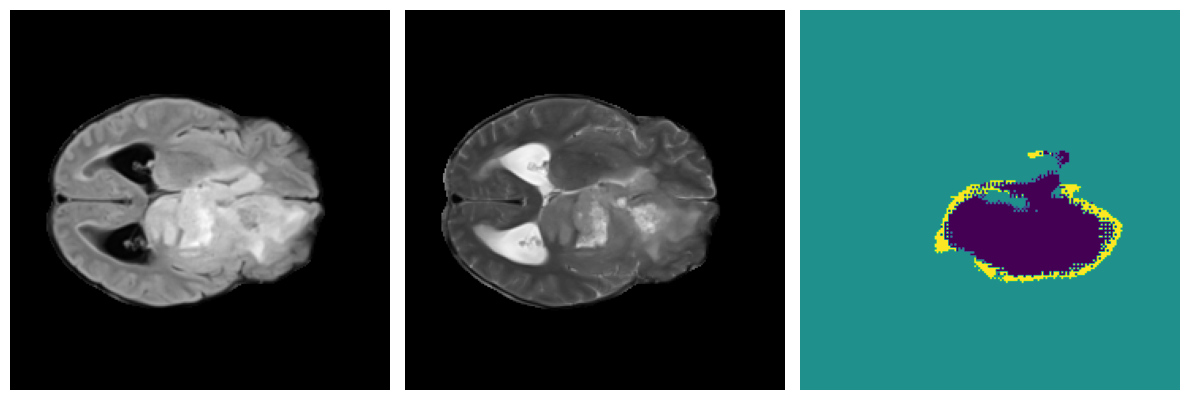

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 75
data = sorted(glob("/scratch/guest187/Data/val_SSA/results/monai_test/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/scratch/guest187/Data/val_SSA/finetune_ssa/images/{fname}-stk.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

# ======================================================================================================================

Old code

In [ ]:
import numpy as np
import time
from tqdm import tqdm
import os
import sys
import torchio as tio
import logging

# import torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# Import MONAI libraries                <--- CLEAN UP THESE IMPORTS ONCE WE KNOW WHAT libraries are used
import monai
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader
from monai.handlers import (
    CheckpointLoader,
    IgniteMetric,
    MeanDice,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.metrics import DiceMetric, LossMetric, HausdorffDistanceMetric
from monai.losses import DiceLoss, DiceFocalLoss
from monai.networks import nets as monNets
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose
)
from monai.inferers import sliding_window_inference
from monai.utils import first
from monai.utils.misc import set_determinism

# Other imports (unsure)
# import ignite
import nibabel

import torch
import os
import torch.utils.data as data_utils
import json
from subprocess import call
from sklearn.model_selection import train_test_split
# from utils.utils import get_main_args
import pickle
import glob

import matplotlib.pyplot as plt
from monai.data import Dataset

## Data class

In [ ]:
class MRIDataset(Dataset):
    """
    Given a set of images and corresponding labels (i.e, will give it all training images + labels, and same for val and test)
    folder structure: subjectID/subjectID-stk.npy, -lbl.npy (i.e. contains 2 files)
    """

    def __init__(self, data_dir, data_folders, transform=None, SSAtransform=None):
            self.data_folders = data_folders                            # path for each data folder in the set
            self.transform = transform
            self.SSAtransform = SSAtransform
            self.imgs = []                                              # store images to load (paths)
            self.lbls = []                                              # store corresponding labels (paths)
            for img_folder in self.data_folders:                        # run through each subjectID folder
                folder_path = os.path.join(data_dir, img_folder)                                                            
                self.SSA = True if 'SSA' in img_folder else False       # check if current file is from SSA dataset
                for file in os.listdir(folder_path):                    # check folder contents
                    if os.path.isfile(os.path.join(folder_path, file)):
                        if file.endswith("-lbl.npy"):
                            self.lbls.append(os.path.join(folder_path, file))   # Save segmentation mask (file path)
                            self.mode = "labels"
                        elif file.endswith("-stk.npy"):
                            self.imgs.append(os.path.join(folder_path, file))   # Save image (file path)

    def __len__(self):
        # Return the amount of images in this set
        return len(self.imgs)
    
    def __getitem__(self, idx):
        name = os.path.dirname(self.imgs[idx])
        # Load files
        if self.mode == "labels":
            mask = np.load(self.lbls[idx])
            mask = torch.from_numpy(mask) # 240, 240, 155

        # print(self.imgs[idx] )
        # print("========================")
        # print(self.lbls[idx] )
        # print("========================")           

        if self.transform is not None: # Apply general transformations
        # transforms such as crop, flip, rotate etc will be applied to both the image and the mask
            if self.mode == "labels":
                subject = tio.Subject(
                    image=tio.ScalarImage(tensor=image),
                    mask=tio.LabelMap(tensor=mask)
                    )
                tranformed_subject = self.transform(subject)
                # Apply transformation to GLI data to reduce quality (creating fake SSA data)
                if self.SSA == False and self.SSAtransform is not None:
                    tranformed_subject = self.SSAtransform(tranformed_subject)
            
                print("Tranformed_subject: ", tranformed_subject)
                image = tranformed_subject["image"].data
                mask = tranformed_subject["mask"].data
                return image, mask, self.imgs[idx]
            else:
                subject = tio.Subject(
                    image=tio.ScalarImage(tensor=image),
                    )
                tranformed_subject = self.transform(subject)           
                print("Tranformed_subject: ", tranformed_subject)
                image = tranformed_subject["image"].data
                return image, self.imgs[idx]

        return image, mask, self.imgs[idx]
    
    def get_paths(self):
        return self.img_pth, self.seg_pth
    
    def get_subj_info(self):
        return self.subj_dir_pths, self.subj_dirs
        #, self.SSA
    
    def get_transforms(self):
        return self.transform


In [ ]:
def define_transforms(n_channels):
    # Initialise data transforms
    data_transforms = {
        'train': tio.Compose([
            tio.CropOrPad((192, 192, 124)),
            tio.OneOf([
                tio.Compose([
                    tio.RandomFlip(axes=0, p=0.3),
                    tio.RandomFlip(axes=1, p=0.3),
                    tio.RandomFlip(axes=2, p=0.3)]),
                tio.RandomAffine(degrees=15,p=0.3)
            ], p=0.8),
            tio.EnsureShapeMultiple(2**n_channels, method='pad')
        ]),
        'fakeSSA': tio.OneOf({
            tio.OneOf({
                tio.Compose([
                    tio.Resample((1.2, 1.2, 6), scalars_only=True),
                    tio.Resample(1)
                ]):0.50,
                tio.Compose([
                    tio.RandomAnisotropy(axes=(1, 2), downsampling=(1.2), scalars_only=True),
                    tio.RandomAnisotropy(axes=0, downsampling=(6), scalars_only=True)
                ]):0.5,                
            },p=0.80),
            tio.Compose([            
                tio.OneOf({
                    tio.RandomBlur(std=(0.5, 1.5)) : 0.3,
                    tio.RandomNoise(mean=3, std=(0, 0.33)) : 0.7
                },p=0.50),
                tio.OneOf({
                    tio.RandomMotion(num_transforms=3, image_interpolation='nearest') : 0.5,
                    tio.RandomBiasField(coefficients=1) : 0.2,
                    tio.RandomGhosting(intensity=1.5) : 0.3
                }, p=0.50)
            ])
        }, p=0.8), # randomly apply ONE of these given transforms with prob 0.5 
        'val': tio.Compose([
            tio.CropOrPad((192, 192, 124)),
            tio.EnsureShapeMultiple(2**n_channels, method='pad')
        ]),
        'test' : tio.Compose([
            tio.EnsureShapeMultiple(2**n_channels, method='pad')
        ])
    }

    return data_transforms

In [ ]:
def load_data(args, data_transforms):

    '''
    This function is called during training after define_transforms(n_channels)

    It takes as input
        args: argparsers from the utils script 
            args.seed
            args.data_used: 'all', 'GLI', 'SSA'
        data_transforms: a dictionary of transformations to apply to the data during training

    Returns dataloaders ready to be fed into model
    '''
    logger = logging.getLogger(__name__)

    # Set a seed for reproducibility if you want the same split - optional
    if args.seed != None:
        seed=args.seed
        logger.info(f"Seed set to {seed}.")
    else:
        seed=None
        logger.info("No seed has been set")
    
    # Locate data based on which dataset is being used
    if args.data_used == 'all':
        data_folders = glob.glob(os.path.join(args.data, "BraTS*"))
    elif args.data_used == "GLI":
        data_folders = [folder for folder in os.listdir(args.data) if 'GLI' in folder]
    elif args.data_used == 'SSA':
        data_folders = [folder for folder in os.listdir(args.data) if 'SSA' in folder]

    # Split data files
    train_files, val_files = split_data(data_folders, seed) 
    logger.info(f"Number of training files: {len(train_files)}\nNumber of validation files: {len(val_files)}")
    
    image_datasets = {
        'train': MRIDataset(args.data, train_files, transform=data_transforms['train']),
        'val': MRIDataset(args.data, val_files, transform=data_transforms['val']),
    }

    # Create dataloaders
    # can set num_workers for running sub-processes
    dataloaders = {
        'train': data_utils.DataLoader(image_datasets['train'], batch_size=args.batch_size, shuffle=True, drop_last=True),
        'val': data_utils.DataLoader(image_datasets['val'], batch_size=args.val_batch_size, shuffle=True)
        # 'test': data_utils.DataLoader(image_datasets['test'], batch_size=args.val_batch_size, shuffle=True)
    }

    # Save data split
    splitData = {
        'subjsTr' : train_files,
        'subjsVal' : val_files,
        # 'subjsTest' : test_files    
    }
    with open(args.data + str(args.data_used) + ".json", "w") as file:
        json.dump(splitData, file)

    return dataloaders

def split_data(data_folders, seed):
    '''
    Function to split dataset into train/val/test splits, given all avilable data.
    Input:
        list of paths to numpy files
    Returns:
        lists for each train and val/test sets, where each list contains the file names to be used in the set
    '''
    #-----------------------------
    # originally we split as 3: train-test-val train (70), val (15), test (15):
        # train_files, test_files = train_test_split(data_folders, test_size=0.7, random_state=seed)
        # val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=seed)

    #-----------------------------
    # training loop split is train-val (70-30)
    train_files, val_files = train_test_split(data_folders, test_size=0.7, random_state=seed)

    # ??? validation/testing???

    return train_files, val_files

## Helper Functions

In [ ]:
"""Setup transforms, dataset"""
def define_dataloaders(n_channels):
    # Define transforms
    data_transform = define_transforms(n_channels)
    # Load data
    dataloaders = load_data(args, data_transform)                      # this also saves a json splitData
    # train_loader, val_loader = dataloaders['train'], dataloaders['val']
    return dataloaders

In [ ]:
"""Define model architecture:
        Done before data loader so that transforms has n_channels for EnsureShapeMultiple
"""
def define_model(checkpoint=None):
    model=UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=4,
        channels=(16, 32, 64, 128, 256),
        # channels=(32, 64, 128, 256, 320, 320), #nnunet channels, depth 6
        # channels=(64, 96, 128, 192, 256, 384, 512), # optinet, depth 7
        strides=(2, 2, 2, 2), # length should = len(channels) - 1
        # kernel_size=,
        # num_res_units=,
        # dropout=0.0,
        )
    n_channels = len(model.channels)
    print(f"Number of channels: {n_channels}")

    if checkpoint != None:
        model.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))

    return model, n_channels

"""
Setup validation stuff
    metrics
    post trans ???????
    define inference
"""
def val_params():
    VAL_AMP = True
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=True, num_classes=4)
    dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch", get_not_nans=True, num_classes=4)
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    return VAL_AMP, dice_metric, dice_metric_batch, post_trans

# define inference method
def inference(VAL_AMP, model, input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=None, ## best to leave as None, computes itself (else NEEDS TO BE BASED ON LAYER IN, OUT E.G., Conv3d(4, 16; Conv3d(16, 32; etc)
            # roi_size=(128, 128, 64),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
            mode='gaussian'
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

## Define model

In [ ]:
"""General Setup: 
    logging,
    utils.args 
    seed,
    cuda, 
    root dir"""
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# args = get_main_args()
seed = 42
set_determinism(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# root_dir = args.data
# results_dir = args.results

model, n_channels = define_model()
model.to(device)

## Inference

File paths for Alex's local system

In [ ]:
validation_dir= '/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/data/val_SSA'
validation_files = [os.path.join(validation_dir, file) for file in os.listdir(validation_dir)]

# checkpoint to test: /scratch/guest187/Data/train_all/results/test_run/best_metric_model.pth 
checkpoint = '/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/data/best_metric_model_fullTest.pth'

# Load validation data to dataloader
data_transforms = define_transforms(n_channels)
validation_dataset = MRIDataset(validation_dir, validation_files, transform=data_transforms['val'])

# Validation parameters
VAL_AMP, dice_metric, dice_metric_batch, post_transforms = val_params()

## Check best model output with the input image and label

In [ ]:
print(len(validation_dataset))
img, image_path = validation_dataset[0]
print(img.shape)

In [ ]:
model, n_channels = define_model(checkpoint)
model.to(device)
model.eval()

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input, _ = validation_dataset[0]
    print(val_input.shape)
    # roi_size = (128, 128, 64)
    # sw_batch_size = 4
    val_output = inference(VAL_AMP, model, val_input)
    val_output = post_transforms(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(validation_dataset[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(validation_dataset[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()